<a href="https://colab.research.google.com/github/royal-dit/tensorflow-deeplearning/blob/main/colorization_using_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/Joeclinton1/google-images-download.git

In [ ]:
#helper function
!wget https://raw.githubusercontent.com/royal-dit/tensorflow-deeplearning/main/helper_func.py 
from helper_func import  unzip_data,create_tensorboard_callback,plot_loss_curves,make_confusion_matrix,compare_historys,walk_through_dir

--2022-10-19 05:15:47--  https://raw.githubusercontent.com/royal-dit/tensorflow-deeplearning/main/helper_func.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12051 (12K) [text/plain]
Saving to: ‘helper_func.py.1’

helper_func.py.1    100%[===================>]  11.77K  --.-KB/s    in 0s      

2022-10-19 05:15:47 (119 MB/s) - ‘helper_func.py.1’ saved [12051/12051]



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

In [ ]:
!wget https://www.kaggle.com/datasets/pankrzysiu/cifar10-python/download?datasetVersionNumber=1

In [ ]:
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip")
zip_ref.extractall()
zip_ref.close()

In [ ]:
from tensorflow.keras import datasets,layers,models

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D,UpSampling2D,Input
from keras.models import Model,Sequential
from keras.preprocessing.image import ImageDataGenerator
from skimage.color import rgb2lab,lab2rgb,gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np 
import matplotlib.pyplot as plt

In [ ]:
from google_images_download import google_images_download
response = google_images_download.googleimagesdownload()
arguments = {"keywords":"humanfaces,men face,women face, old person face,childface,girl face,black people face,american people face","limit":100,"print_urls":False}
paths=response.download(arguments)
print(paths)

In [ ]:
path = '/content/10_food_classes_all_data/train'
path2 = '/content/custom_food_images'
path3='/content/drive/MyDrive/Colab Notebooks/random images/downloads'
train_datagen = ImageDataGenerator(rescale=1./255)
train = train_datagen.flow_from_directory(path3,
                                          target_size = (224,224),
                                          # batch_size = 32,
                                          class_mode = None
                                          )


Found 41048 images belonging to 66 classes.


In [ ]:
X=[] #lightness
Y=[]  #color channel
for img in train[0]:
  try:
      lab = rgb2lab(img)
      X.append(lab[:,:,0]) # this is lightness channel
      Y.append(lab[:,:,1:]/128) #this is along x axis in lab
  except:
    print('error')
X = np.array(X)
Y=np.array(Y)
X=X.reshape(X.shape+(1,))



In [ ]:
X.shape


(32, 224, 224, 1)

#using vgg16 archetecture

In [ ]:
from keras.applications.vgg16 import VGG16
vggmodel = VGG16()

553467096/553467096 [==============================] - 3s 0us/step


In [ ]:
newmodel = Sequential()
for i,layer in enumerate(vggmodel.layers):
  if i <19:
    newmodel.add(layer)
newmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [ ]:
for layer in newmodel.layers:
  layer.trainable = False


#Inception v3 archetecture


In [ ]:
from keras.applications.inception_v3 import InceptionV3


In [ ]:
Inception_model = InceptionV3(weights='imagenet',
                              include_top = True,
                                                     )
Inception_model.trainable = False

In [ ]:
Inception_model.summary()

#training model

In [ ]:
# rehsaping the X shape becasue the vgg model takes (1,224,224,3) instead pf (1,224,224,1)

vggfeatures = []
for i, sample in enumerate(X):
  sample = gray2rgb(sample)
  # sample=tf.reshape(sample,[1,224,224,3])
  sample = sample.reshape((1,224,224,3))
  prediction = newmodel.predict(sample)
  prediction = prediction.reshape((7,7,512))
  vggfeatures.append(prediction)
vggfeatures = np.array(vggfeatures)
print(vggfeatures.shape)

1/1 [==============================] - 0s 482ms/step
(32, 7, 7, 512)


In [ ]:
#decoder part


In [ ]:
model = Sequential([
    tf.keras.layers.Conv2D(256,(3,3),activation='tanh',padding='same',input_shape=(7,7,512)),
    tf.keras.layers.Conv2D(128,(3,3),activation='tanh',padding='same'),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation='tanh',padding='same'),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(32,(3,3),activation='tanh',padding='same'),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(16,(3,3),activation='tanh',padding='same'),
    # tf.keras.layers.Conv2D(8,(3,3),activation='tanh',padding='same'),
    # tf.keras.layers.Conv2D(4,(3,3),activation='tanh',padding='same'),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(2,(3,3),activation='tanh',padding='same'),
    tf.keras.layers.UpSampling2D((2,2))
])

In [ ]:
# model = Sequential([
#     tf.keras.layers.Conv2D(64,(3,3),activation='tanh',padding='same',input_shape=(7,7,512)),
#     tf.keras.layers.Conv2D(128,(3,3),activation='tanh',padding='same'),
#     tf.keras.layers.Conv2D(128,(3,3),activation='tanh',padding='same'),
#     tf.keras.layers.Conv2D(256,(3,3),activation='tanh',padding='same'),
#     tf.keras.layers.Conv2D(256,(3,3),activation='tanh',padding='same'),
#     tf.keras.layers.Conv2D(512,(3,3),activation='tanh',padding='same'),
#     tf.keras.layers.Conv2D(512,(3,3),activation='tanh',padding='same'),
#     tf.keras.layers.Conv2D(256,(3,3),activation='tanh',padding='same'),
# #decoder
#     tf.keras.layers.Conv2D(128,(3,3),activation='tanh',padding='same'),

#     tf.keras.layers.UpSampling2D((2,2)),
#     tf.keras.layers.Conv2D(64,(3,3),activation='tanh',padding='same'),
#     tf.keras.layers.UpSampling2D((2,2)),
#     tf.keras.layers.Conv2D(32,(3,3),activation='tanh',padding='same'),
#     tf.keras.layers.UpSampling2D((2,2)),
#     tf.keras.layers.Conv2D(16,(3,3),activation='tanh',padding='same'),
#     tf.keras.layers.UpSampling2D((2,2)),
#     tf.keras.layers.Conv2D(2,(3,3),activation='tanh',padding='same'),
#     tf.keras.layers.UpSampling2D((2,2))
# ])

In [ ]:
model = Sequential([
    tf.keras.layers.Conv2D(512,(3,3),activation='relu',padding='same',input_shape=(7,7,512)),
    tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same'),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same'),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(16,(3,3),activation='relu',padding='same'),
    
    tf.keras.layers.Conv2D(8,(3,3),activation='relu',padding='same'),
   
    tf.keras.layers.Conv2D(2,(3,3),activation='relu',padding='same'),
    tf.keras.layers.UpSampling2D((2,2)),
])

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 7, 7, 256)         1179904   
                                                                 
 conv2d_37 (Conv2D)          (None, 7, 7, 128)         295040    
                                                                 
 up_sampling2d_30 (UpSamplin  (None, 14, 14, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 14, 14, 64)        73792     
                                                                 
 up_sampling2d_31 (UpSamplin  (None, 28, 28, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_39 (Conv2D)          (None, 28, 28, 32)       

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 7, 7, 256)         1179904   
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         295040    
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        73792     
                                                                 
 up_sampling2d_1 (UpSampling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)       

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='mae',metrics=['accuracy'])
history = model.fit(vggfeatures,Y,epochs=250)

Epoch 1/250
1/1 [==============================] - 2s 2s/step - loss: 0.9577 - accuracy: 0.2948
Epoch 2/250
1/1 [==============================] - 1s 1s/step - loss: 0.9577 - accuracy: 0.2948
Epoch 3/250
1/1 [==============================] - 1s 1s/step - loss: 0.9577 - accuracy: 0.2948
Epoch 4/250
1/1 [==============================] - 1s 1s/step - loss: 0.9577 - accuracy: 0.2948
Epoch 5/250
1/1 [==============================] - 1s 1s/step - loss: 0.9577 - accuracy: 0.2948
Epoch 6/250
1/1 [==============================] - 1s 1s/step - loss: 0.9577 - accuracy: 0.2948
Epoch 7/250
1/1 [==============================] - 1s 1s/step - loss: 0.9577 - accuracy: 0.2948
Epoch 8/250


KeyboardInterrupt: ignored

Text(0, 0.5, 'epochs')

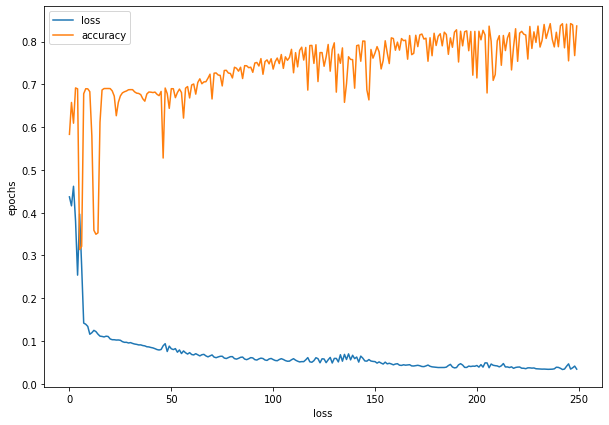

In [ ]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(10,7))
plt.xlabel("loss")
plt.ylabel("epochs")

In [ ]:
plot_loss_curves(history)

#saving and loading model to check test data


In [ ]:
model.save('colorized_vgg16.model')

In [ ]:
# from keras.utils.image_utils import img_to_array
# import os
# #predicting the saved model
# model = tf.keras.models.load_model('/content/colorized_vgg16.model',custom_objects=None,compile=True)
# testpath = '/content/downloads/blac and white nature image/'
# files = os.listdir(testpath)
# for idx,file in enumerate(files):
  # test = img_to_array(tf.keras.preprocessing.image.load_img(testpath+file))
  # test = resize(test,(224,224),anti_aliasing=True)
  # test*= 1.0/255
  # lab = rgb2lab(test)
  # l = lab[:,:,0]
  # L=gray2rgb(l)
  # L = L.reshape((1,224,224,3))
  

  #vggpred = newmodel.predict(L)
  # ab = model.predict(vggpred)
  # ab = ab*128
  # cur = np.zeros((224,224,3))
  # cur[:,:,0] = l
  # cur[:,:,1:] = ab
#   imsave("/content/downloads/blac and white nature image/predicted image.jpg",lab2rgb(cur))


1/1 [==============================] - 0s 115ms/step


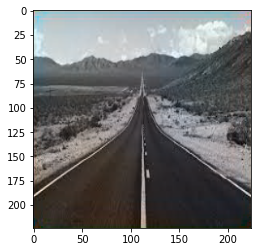

In [ ]:
from keras.utils.image_utils import img_to_array
img1_color = []
img1=img_to_array(tf.keras.preprocessing.image.load_img('/content/road grayscale.jpg'))
# img1=resize(img1,(224,224),anti_aliasing=True)
# img1_color.append(img1)


# img1_color = np.array(img1_color,dtype = float)
# img1_color = rgb2lab(1.0/255*img1_color)[:,:,:,0]
# img1_color = img1_color.reshape(img1_color.shape+(1,))

# output1 = model.predict(img1_color)
# output1=output1*128

# result = np.zeros((224,224,3))
# result[:,:,0] = img1_color[0][:,:,0]
# result[:,:,1:]=output1[0]
# imshow(lab2rgb(result))
# imsave("result.jpg",lab2rgb(result))

test = resize(img1,(224,224),anti_aliasing=False)
test*= 1.0/255
lab = rgb2lab(test)
l = lab[:,:,0]
L=gray2rgb(l)
L = L.reshape((1,224,224,3))
  

vggpred = newmodel.predict(L) 
ab = model.predict(vggpred)
ab = ab*128
cur = np.zeros((224,224,3))
cur[:,:,0] = l
cur[:,:,1:] = ab
plt.figure()
plt.subplot(1,1,1)
plt.imshow(lab2rgb(cur))
imsave("result.jpg",lab2rgb(cur))




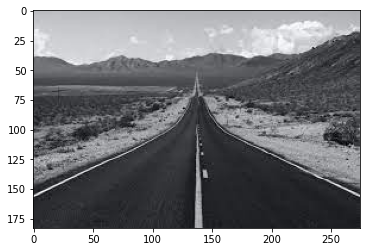

In [ ]:
img_real=tf.keras.preprocessing.image.load_img('/content/road grayscale.jpg')
plt.imshow(img_real)